# Southern Ocean EKE  in OCCIPUT

This notebook is a  first attempt to make sense of EKE in the Southern Ocean from the OCCIPUT ensemble. Note that:
 * EKE files have been calculated approximately from daily SSH, restricted to the Southern Ocean for convenience and resampled monthly.
 * Ensemble members missing files include member 12 (2015), 13 (2014),  17 (2013) and 20 (2011). These members are omitted from the analysis - so we only have 46 members.

### Executive Summary

The intent here is just to see if there is anything to be gained from looking at EKE (as opposed to SLA) in the ensemble simulations (as opposed to a single forced simulation). The answer would appear to be yes. Broadly speaking, we are able to recreate the relationships between wind stress forcing and Southern Ocean EKE, but the presence of the ensemble allows us to fine-grain the regions we look at. With this approach, we can isolate the dynamical behaviour of EKE around individual pieces of topography. It would appear that there are a diverse range of dynamical regimes around the Southern Ocean -- including regions that are forced externally (meaning that all ensemble members track similar paths), regions dominated by internal variability (no correlation between the variations of ensemble members) and regions with  both internal and forced variability. Likewise, the lagged correlation between wind stress and EKE seems to vary strongly as a function of the local dynamics. Furthermore, this EKE approach may allow us to better characterise variability in regions outside the Southern Ocean.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import pandas as pd
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import os 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

## Ensemble Averages
First load the EKE from each member, calculate annual climatology and make ensemble average climatology (`eke_month`).

In [2]:
nfiles = 50
nn=0
for ii in range(1,nfiles+1):
    i00 = '%03d' % ii
    Member = 'ORCA025.L75-OCCITENS.'+i00
    filename='Data/'+Member+'_eke.nc'
    if os.path.exists(filename):
        nn+=1
        eke = xr.open_dataset(filename).EKE
        #print(filename)
        if nn==1:
            eke_month = eke.groupby('time.month').mean('time')
        else:
            eke_month = eke_month + eke.groupby('time.month').mean('time')

eke_month = eke_month/nn


## Plotting Ensemble Averages
Plot the ensemble mean, as well as the seasonal (summer/winter) means, and the seasonal differences. For reference, note  the EKE averaging regions used in Hogg et al. (2015), which are:
* Indian Ocean: 40-150°E, 57-44°S (this box spans the longitude split in ORCA025 output)
* Pacific Ocean: 150-288°E, 62-48°S
* Atlantic Ocean: 325-10°E,56-46°S

Text(0.5,1,'Diff')

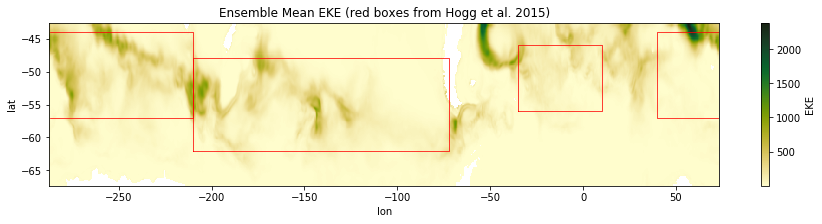

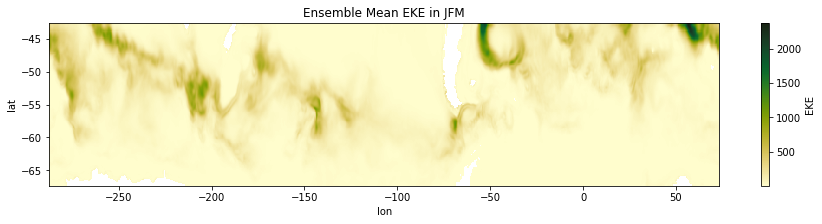

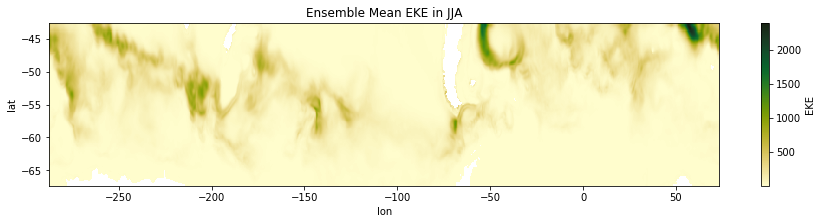

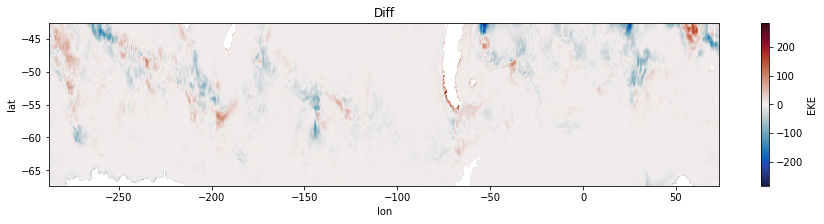

In [3]:
plt.figure(figsize=(15,3))
eke_ensemble_mean = eke_month.mean('month')
eke_ensemble_mean.plot(cmap=cm.cm.speed)
plt.title('Ensemble Mean EKE (red boxes from Hogg et al. 2015)')
plt.plot([-210,-72, -72, -210, -210],[-62, -62,-48, -48, -62],color='r',linewidth=0.75)
plt.plot([-35,10, 10, -35, -35],[-56, -56,-46, -46, -56],color='r',linewidth=0.75)
plt.plot([73, 40, 40, 73],[-57, -57,-44, -44],color='r',linewidth=0.75)
plt.plot([-287, -210, -210, -287],[-57, -57,-44, -44],color='r',linewidth=0.75)

plt.figure(figsize=(15,3))
eke_JFM = eke_month.isel(month=slice(0,3)).mean('month')
eke_JFM.plot(cmap=cm.cm.speed)
plt.title('Ensemble Mean EKE in JFM')

plt.figure(figsize=(15,3))
eke_JJA = eke_month.isel(month=slice(6,9)).mean('month')
eke_JJA.plot(cmap=cm.cm.speed)
plt.title('Ensemble Mean EKE in JJA')

plt.figure(figsize=(15,3))
eke_month_diff = eke_JJA - eke_JFM
eke_month_diff.plot(cmap=cm.cm.balance)
plt.title('Diff')

**This Figure Shows** that there are clear topographic hotspots of EKE in all the expected places. Some places have seasonality of the  eddy  field, but there is nothing systematic.

## Timeseries

Now, let's look at the timeseries of EKE  averaged over the  red boxes shown above, which we have used previously.

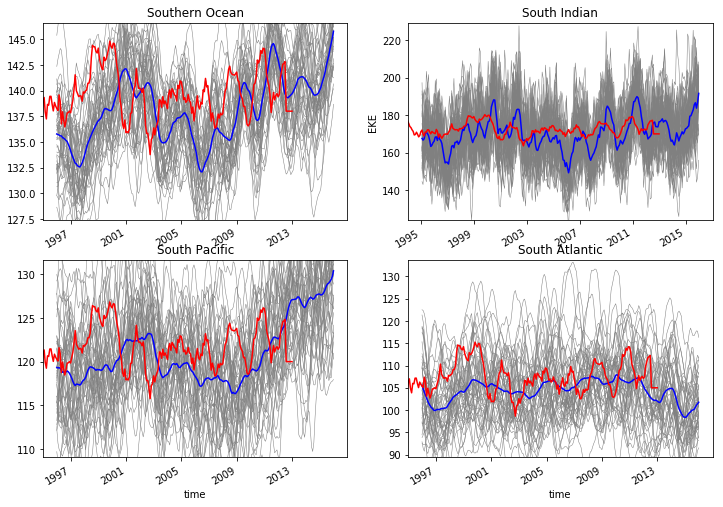

In [22]:
# plot processed data
fig,ax = plt.subplots(2,2,figsize=(12,8))
nfiles = 50
nn=0
for ii in range(1,nfiles+1):
    i00 = '%03d' % ii
    Member = 'ORCA025.L75-OCCITENS.'+i00
    filename='Data/'+Member+'_eke.nc'
    if os.path.exists(filename):
        nn+=1
        eke = xr.open_dataset(filename).EKE
        #print(filename)
        #print(eke)
        # Total
        eke_tot = eke.mean('lon').sel(lat=slice(-58,-40)).mean('lat').rolling(time=12).mean()
        eke_tot.plot(ax=ax[0,0],label=i00,color=[0.5, 0.5, 0.5],linewidth=0.5)
        # Pacific
        eke_pac = eke.sel(lon=slice(-210,-72)).sel(lat=slice(-62,-48)).mean('lon').mean('lat')\
                        .rolling(time=12).mean()#.resample(time='A').mean('time')
        eke_pac.plot(ax=ax[1,0],label=i00,color=[0.5, 0.5, 0.5],linewidth=0.5)
        #Indian
        eke_ind = (77*eke.sel(lon=slice(-287,-210)).sel(lat=slice(-57,-44)).mean('lon').mean('lat') 
                       +  33*eke.sel(lon=slice(40,73)).sel(lat=slice(-57,-44)).mean('lon').mean('lat'))/110
        #eke_ind  =  eke_ind.rolling(time=12).mean()
        eke_ind.plot(ax=ax[0,1],label=i00,color=[0.5, 0.5, 0.5],linewidth=0.5)
        # Atlantic
        eke_atl = eke.sel(lon=slice(-35,10)).sel(lat=slice(-56,-46)).mean('lon').mean('lat')\
                        .rolling(time=12).mean()#.resample(time='A').mean('time')
        eke_atl.plot(ax=ax[1,1],label=i00,color=[0.5, 0.5, 0.5],linewidth=0.5)

        if nn==1:
            eke_tot_sum = eke_tot
            eke_pac_sum = eke_pac
            eke_ind_sum = eke_ind
            eke_atl_sum = eke_atl
        else:
            eke_tot_sum = eke_tot_sum + eke_tot
            eke_pac_sum = eke_pac_sum + eke_pac
            eke_ind_sum = eke_ind_sum + eke_ind
            eke_atl_sum = eke_atl_sum + eke_atl
    #else:
        #print('Missing File ',i00)
        
eke_tot_sum = eke_tot_sum/nn
eke_tot_sum.plot(ax=ax[0,0],color='b',linewidth=1.5)

eke_pac_sum = eke_pac_sum/nn
eke_pac_sum.plot(ax=ax[1,0],color='b',linewidth=1.5)

eke_ind_sum = eke_ind_sum/nn
eke_ind_sum.plot(ax=ax[0,1],color='b',linewidth=1.5)

eke_atl_sum = eke_atl_sum/nn
eke_atl_sum.plot(ax=ax[1,1],color='b',linewidth=1.5)

#ax[0,0].legend()
ax[0,0].set_title('Southern Ocean')
ax[0,0].set_xlabel('')
ax[1,0].set_title('South Pacific')
ax[0,1].set_title('South Indian')
ax[0,1].set_xlabel('')
ax[1,1].set_title('South Atlantic')

# Add SAM
data = np.load('running_mean_sam.npz')
samtime = pd.date_range(start='1/1/1957', end='31/12/2012', freq='M')
samfilt = data['samfilt']
ax[0,0].plot(samtime,4*samfilt+138,'r')
ax[0,1].plot(samtime,6*samfilt+170,'r')
ax[1,0].plot(samtime,4*samfilt+120,'r')
ax[1,1].plot(samtime,6*samfilt+105,'r')


**This Figure Shows** the EKE timeseries of individual ensemble members in grey and the ensemble mean in blue for the entire SO, and for the 3 individual sectors. There is the expected interannual  peak from 2001-03 (consistent with a SAM  peak in 1998-99 and a 2-3 year lag; see Meredith & Hogg, 2006); but we only see this in the Pacific and (to a lesser extent) the Indian sector. There is also a trend in the Pacific and perhaps the Indian. The Indian sector has some interannual  variability which may have a relationship with the SAM (shown in the red line). 

The ensemble runs shown here are  much cleaner than previous analyses we have done, leading to the possibility of using smaller averaging regions to tease out the different dynamics at play. In the following, we break EKE down into a few randomly chosen regions, to highlight how we may be able to use these diagnostics. 

In [24]:
def plot_eke_box(lon1,  lon2, lat1,  lat2):
    plt.figure(figsize=(8.5,2.5))
    eke_ensemble_mean = eke_month.mean('month')
    eke_ensemble_mean.plot(cmap=cm.cm.speed,add_colorbar=False,vmax=2000)
    plt.title('Ensemble Mean EKE')
    plt.plot([lon2, lon1, lon1, lon2, lon2],[lat1, lat1, lat2, lat2, lat1],color='r',linewidth=0.75)

    plt.figure(figsize=(9,6))
    nfiles = 50
    nn=0
    for ii in range(1,nfiles+1):
        i00 = '%03d' % ii
        Member = 'ORCA025.L75-OCCITENS.'+i00
        filename='Data/'+Member+'_eke.nc'
        if os.path.exists(filename):
            nn+=1
            eke = xr.open_dataset(filename).EKE
            eke_box = eke.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')\
                              .rolling(time=12).mean()
            eke_box.plot(color=[0.5, 0.5, 0.5],linewidth=0.5)
            if nn==1:
                eke_box_sum = eke_box
            else:
                eke_box_sum = eke_box_sum + eke_box
        
    eke_box_sum = eke_box_sum/nn
    eke_box_sum.plot(color='b',linewidth=1.5)
    plt.title('Timeseries of EKE')


## SW Pacific
Similar to  entire South Pacific box shown  above.

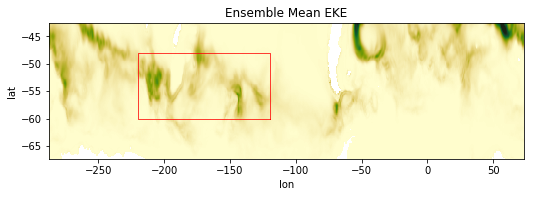

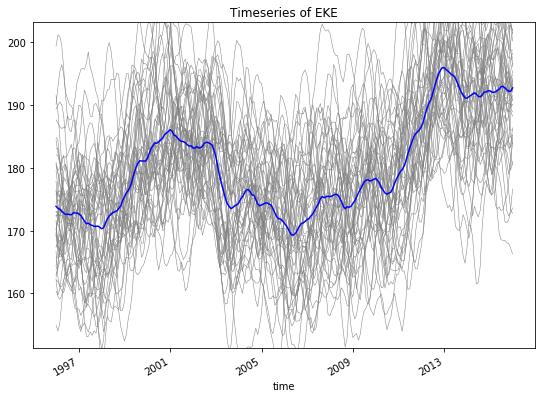

In [194]:
plot_eke_box(-220,  -120, -60,  -48)

## Campbell Plateau
Also similar to the entire South Pacific - this small region appears to dominate the Pacific EKE variability and trends.

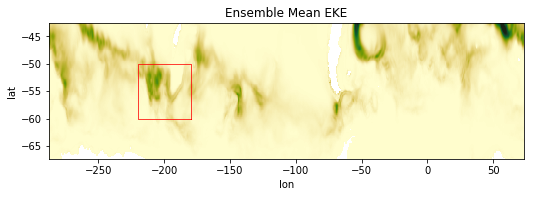

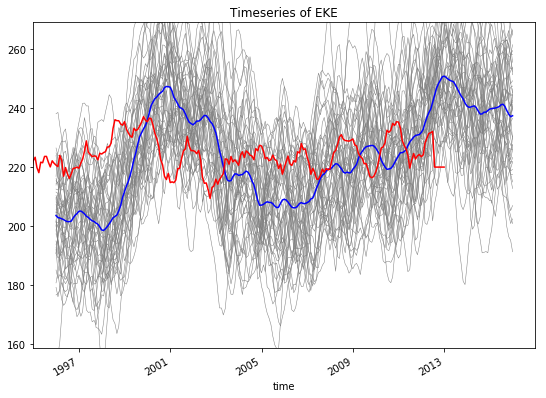

In [25]:
plot_eke_box(-220,  -180, -60,  -50)
plt.plot(samtime,10*samfilt+220,'r')

## South West Pacific ex Campbell Plateau
Shows no forced variability or trend!!

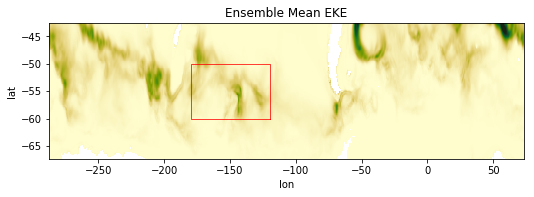

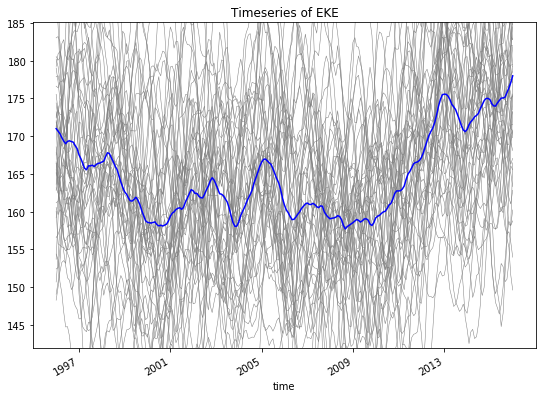

In [196]:
plot_eke_box(-180,  -120, -60,  -50)

## Agulhas retroflection
Didn't quite include the full area here, but this region seems to be dominated by intrinsic variability.

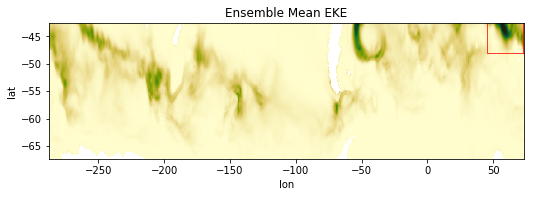

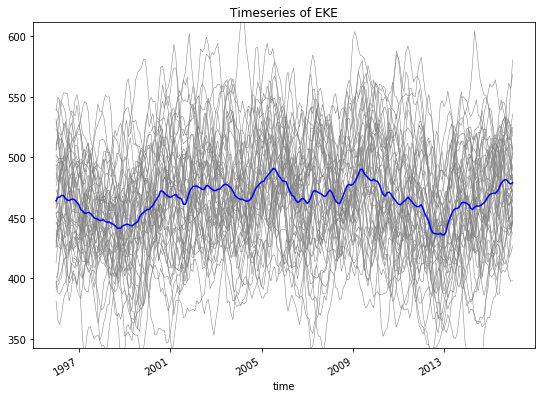

In [197]:
plot_eke_box(45,  73, -48,  -42)

## Malvinas
Some interesting dips here in 2004, 2013 which appear to be forced. Again, would like to expand this area slightly.

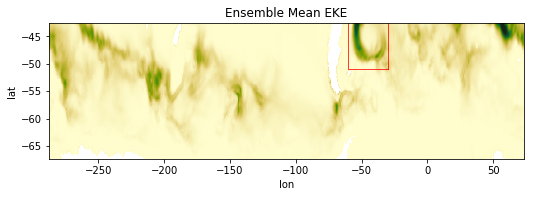

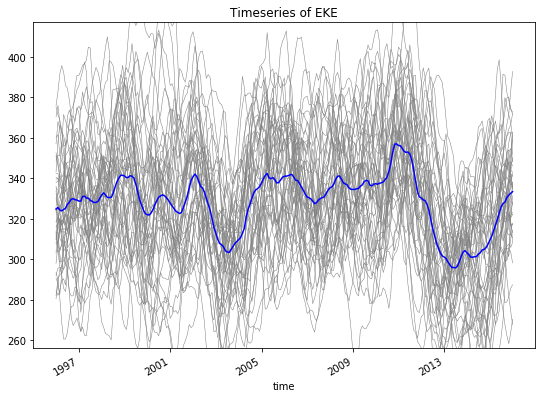

In [198]:
plot_eke_box(-60,  -30, -51,  -42)

## Kerguelen
Clearly forced variability with a 2-3 year frequency???

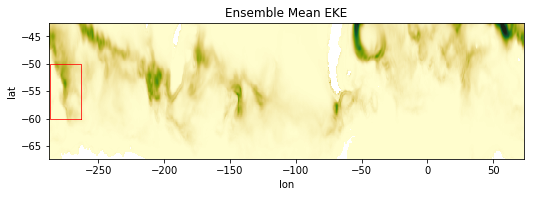

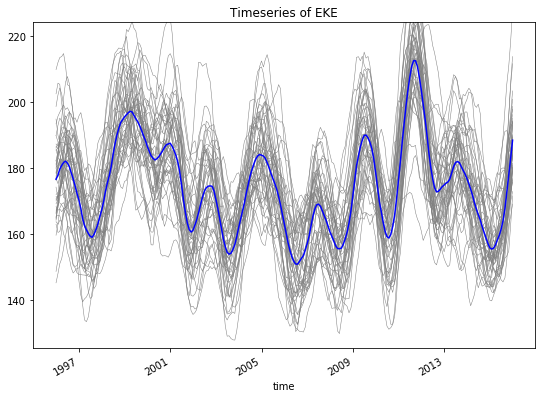

In [206]:
plot_eke_box(-287,  -263, -60,  -50)

## SouthEast Indian Ocean
A long-term trend and forced anomaly from the SAM in 2001.

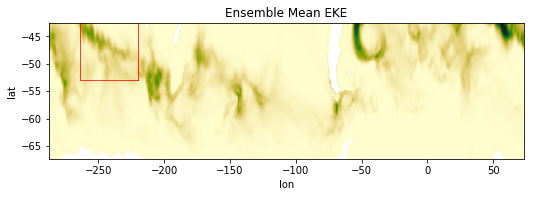

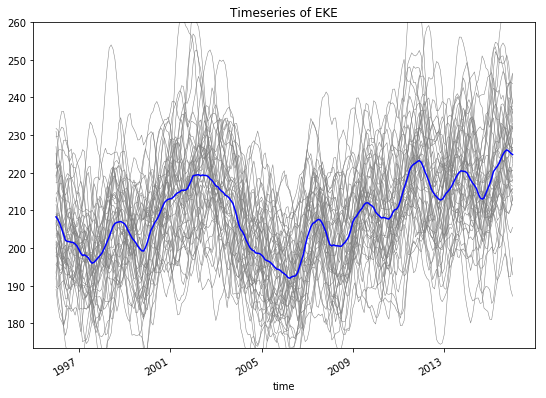

In [200]:
plot_eke_box(-264,  -220, -53,  -42)

## Larger South Atlantic box
Dominated by intrinsic variability.

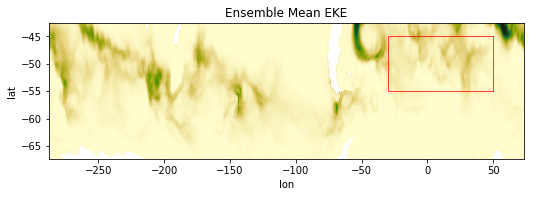

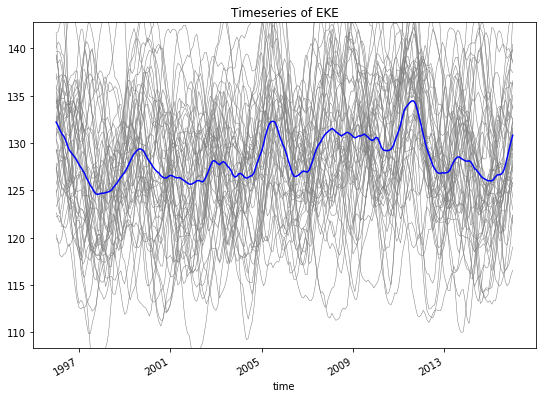

In [205]:
plot_eke_box(-30,  50, -55,  -45)

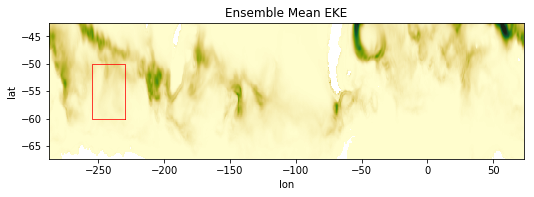

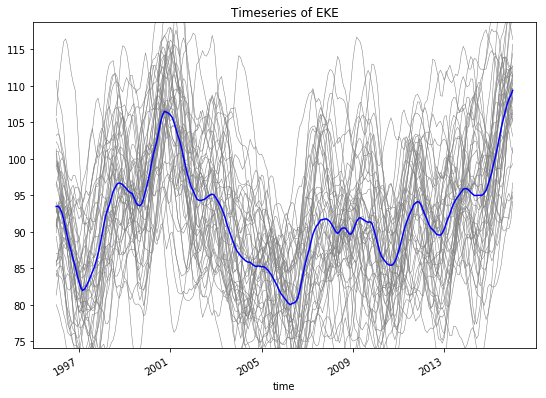

In [27]:
plot_eke_box(-255,  -230, -60,  -50)

## To Do Next:
* Look at signal to noise ratio?
* Map the max correlation between local forcing and EKE?
* Bin behaviour into "depth" bins, or topographic gradient bins?
* Use proper EKE data (Sally to provide).
* Get model wind stress for local correlation tests.